### Updated:  **Notebook Imports**

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from scipy.stats import skew

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier


from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, roc_curve
import scikitplot as skplt

import optuna

import tensorflow as tf

### Updated:  **Loading Data**

In [5]:
data = pd.read_csv('Customer-Churn.csv')
print(f'Number of rows: {data.shape[0]}')
print(f'Number of columns: {data.shape[1]}')

Number of rows: 7043
Number of columns: 21


In [6]:
data.head(3)

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes


### Updated:  **Data Preprocessing**

I will start off by dropping the customerID column as it will of no use in our analysis 

In [7]:
data.drop('customerID', axis=1, inplace= True)

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            7043 non-null   object 
 1   SeniorCitizen     7043 non-null   int64  
 2   Partner           7043 non-null   object 
 3   Dependents        7043 non-null   object 
 4   tenure            7043 non-null   int64  
 5   PhoneService      7043 non-null   object 
 6   MultipleLines     7043 non-null   object 
 7   InternetService   7043 non-null   object 
 8   OnlineSecurity    7043 non-null   object 
 9   OnlineBackup      7043 non-null   object 
 10  DeviceProtection  7043 non-null   object 
 11  TechSupport       7043 non-null   object 
 12  StreamingTV       7043 non-null   object 
 13  StreamingMovies   7043 non-null   object 
 14  Contract          7043 non-null   object 
 15  PaperlessBilling  7043 non-null   object 
 16  PaymentMethod     7043 non-null   object 


`SeniorCitizen` column has an integer datatype and it is clearly a categorical variable, also the `TotalCharges` column has an object datatype and is a numerical feature, so I will convert them to correct datatypes.

In [9]:
print(data['SeniorCitizen'].unique())
print(data['TotalCharges'].nunique())

[0 1]
6531


In [10]:
data['SeniorCitizen'] = data['SeniorCitizen'].astype(str)

In [11]:
data['TotalCharges'] = data['TotalCharges'].replace(' ', np.NaN) # This column had missing values represented by ' '. I noticed it when I tried converting it to float and it gave me an error that it could not convert string to float
data['TotalCharges'] = data['TotalCharges'].astype(float)
data['TotalCharges'] = data['TotalCharges'].fillna(data['TotalCharges'].median()) # I will fill the missing values with median

In [12]:
unique_values = {column: list(data[column].unique()) for column in data.select_dtypes(object).columns}
for key, value in unique_values.items():
    print(f'{key} : {value}')

gender : ['Female', 'Male']
SeniorCitizen : ['0', '1']
Partner : ['Yes', 'No']
Dependents : ['No', 'Yes']
PhoneService : ['No', 'Yes']
MultipleLines : ['No phone service', 'No', 'Yes']
InternetService : ['DSL', 'Fiber optic', 'No']
OnlineSecurity : ['No', 'Yes', 'No internet service']
OnlineBackup : ['Yes', 'No', 'No internet service']
DeviceProtection : ['No', 'Yes', 'No internet service']
TechSupport : ['No', 'Yes', 'No internet service']
StreamingTV : ['No', 'Yes', 'No internet service']
StreamingMovies : ['No', 'Yes', 'No internet service']
Contract : ['Month-to-month', 'One year', 'Two year']
PaperlessBilling : ['Yes', 'No']
PaymentMethod : ['Electronic check', 'Mailed check', 'Bank transfer (automatic)', 'Credit card (automatic)']
Churn : ['No', 'Yes']


There are several features in our dataset like Online Security which has both `No` and `No internet sercvice` as a value. As this both values are essentially the same thing, I will convert it to one

In [13]:
data['MultipleLines'] = data['MultipleLines'].replace('No phone service', 'No')
data[['OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
      'TechSupport', 'StreamingTV', 'StreamingMovies']] = data[['OnlineSecurity', 'OnlineBackup', 
                                                                'DeviceProtection', 'TechSupport', 
                                                                'StreamingTV', 'StreamingMovies']].replace('No internet service', 'No')

In [14]:
unique_values = {column: list(data[column].unique()) for column in data.select_dtypes(object).columns}
for key, value in unique_values.items():
    print(f'{key} : {value}')

gender : ['Female', 'Male']
SeniorCitizen : ['0', '1']
Partner : ['Yes', 'No']
Dependents : ['No', 'Yes']
PhoneService : ['No', 'Yes']
MultipleLines : ['No', 'Yes']
InternetService : ['DSL', 'Fiber optic', 'No']
OnlineSecurity : ['No', 'Yes']
OnlineBackup : ['Yes', 'No']
DeviceProtection : ['No', 'Yes']
TechSupport : ['No', 'Yes']
StreamingTV : ['No', 'Yes']
StreamingMovies : ['No', 'Yes']
Contract : ['Month-to-month', 'One year', 'Two year']
PaperlessBilling : ['Yes', 'No']
PaymentMethod : ['Electronic check', 'Mailed check', 'Bank transfer (automatic)', 'Credit card (automatic)']
Churn : ['No', 'Yes']


In [15]:
data['tenure'].value_counts(ascending= False)
# Updated:  0 appears 11 times, and minimum contract possible is a month-to-month contract, so I will count it as missing value and will fill it with median

tenure
1     613
72    362
2     238
3     200
4     176
     ... 
28     57
39     56
44     51
36     50
0      11
Name: count, Length: 73, dtype: int64

In [16]:
data['tenure']  = data['tenure'].replace(0, np.NaN)
data['tenure'] = data['tenure'].fillna(data['tenure'].median())

### Updated:  **EDA**

In [17]:
data['Churn'].value_counts()

Churn
No     5174
Yes    1869
Name: count, dtype: int64

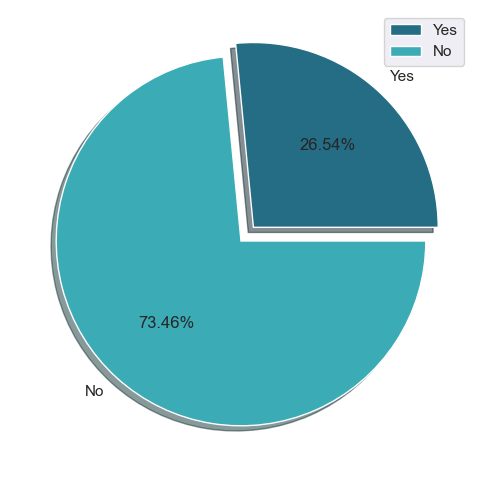

In [18]:
plt.figure(figsize= (10, 6))
data_pie  = [1869 , 5174]
labels = ["Yes", "No"]
explode = [0.1, 0]
plt.pie(data_pie ,labels= labels , explode = explode , autopct="%1.2f%%", shadow= True, colors= ['#256D85', '#3BACB6'])
plt.legend()
plt.show()

We clearly have a imbalanced dataset. Out of all the customers, `73.46%` of people won't churn. We will have to take that into account while splitting the dataset

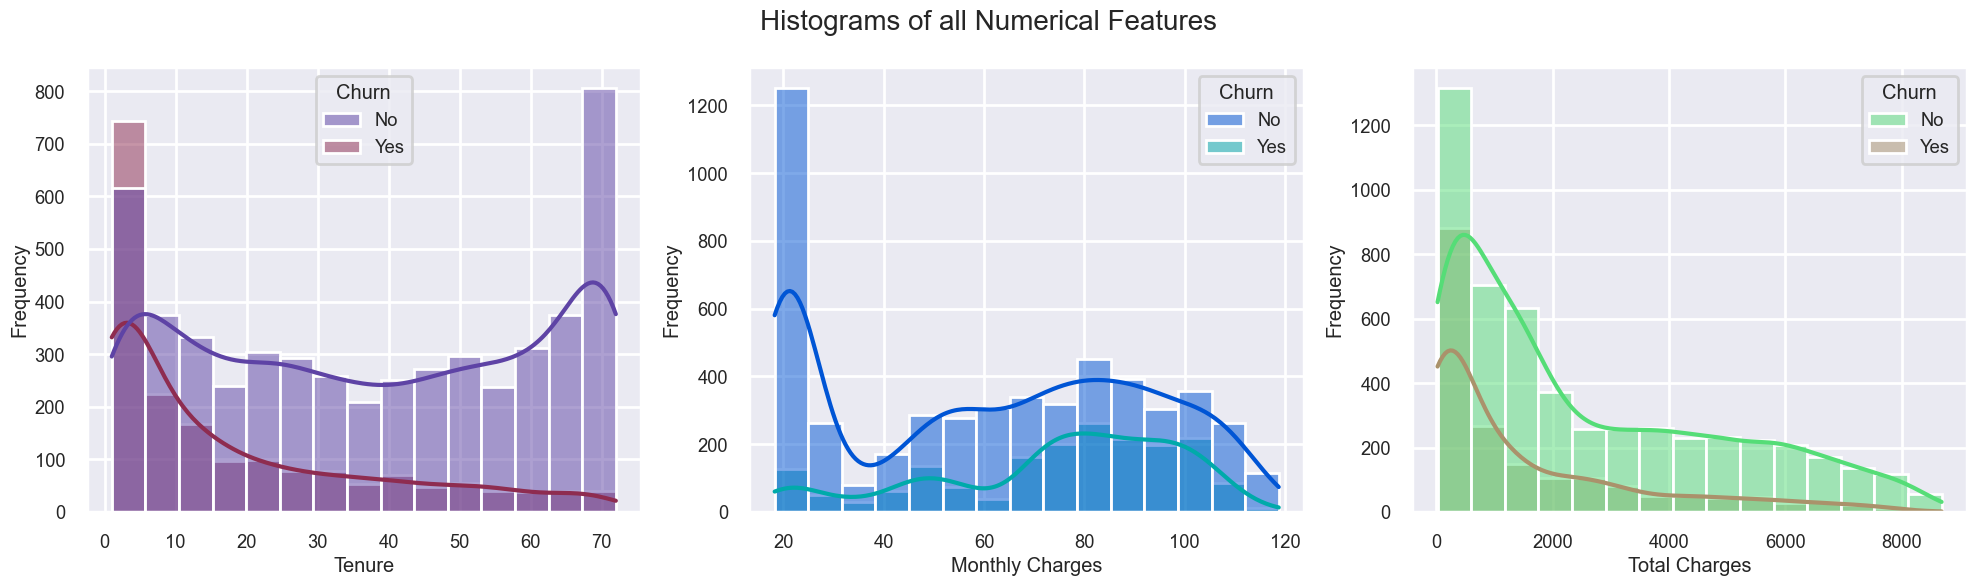

In [19]:
sns.set_context('poster', font_scale= 0.6)
fig, ax  = plt.subplots(1, 3, figsize=(20, 6))

plt.suptitle('Histograms of all Numerical Features', fontsize = 20)

ax1 = sns.histplot(x = data['tenure'],color= 'teal', hue= data['Churn'], ax= ax[0], bins= 15, kde= True, palette= 'twilight')
ax1.set(xlabel= 'Tenure', ylabel= 'Frequency')

ax2 = sns.histplot(x = data['MonthlyCharges'], color= 'teal', hue= data['Churn'], ax= ax[1], bins= 15, kde= True, palette= 'winter')
ax2.set(xlabel= 'Monthly Charges', ylabel= 'Frequency')

ax3 = sns.histplot(x = data['TotalCharges'], color= 'teal', hue= data['Churn'], ax= ax[2], bins= 15, kde= True, palette= 'terrain')
ax3.set(xlabel= 'Total Charges', ylabel= 'Frequency')

plt.tight_layout()
plt.show()

The more months the customer stays with the company, the less likely it is that he/she will churn. Also, the total charges column is clearly skewed, I will apply log transformation later.

/var/folders/f6/s8p4_84101l8gy61qszps_c40000gn/T/ipykernel_11867/1255865877.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax1 = sns.boxplot(y = data['tenure'], x= data['Churn'], ax= ax[0], palette= 'summer')
/var/folders/f6/s8p4_84101l8gy61qszps_c40000gn/T/ipykernel_11867/1255865877.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax2 = sns.boxplot(y = data['MonthlyCharges'], x= data['Churn'], ax= ax[1], palette= 'Blues')
/var/folders/f6/s8p4_84101l8gy61qszps_c40000gn/T/ipykernel_11867/1255865877.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax3 = sns.boxplot(y

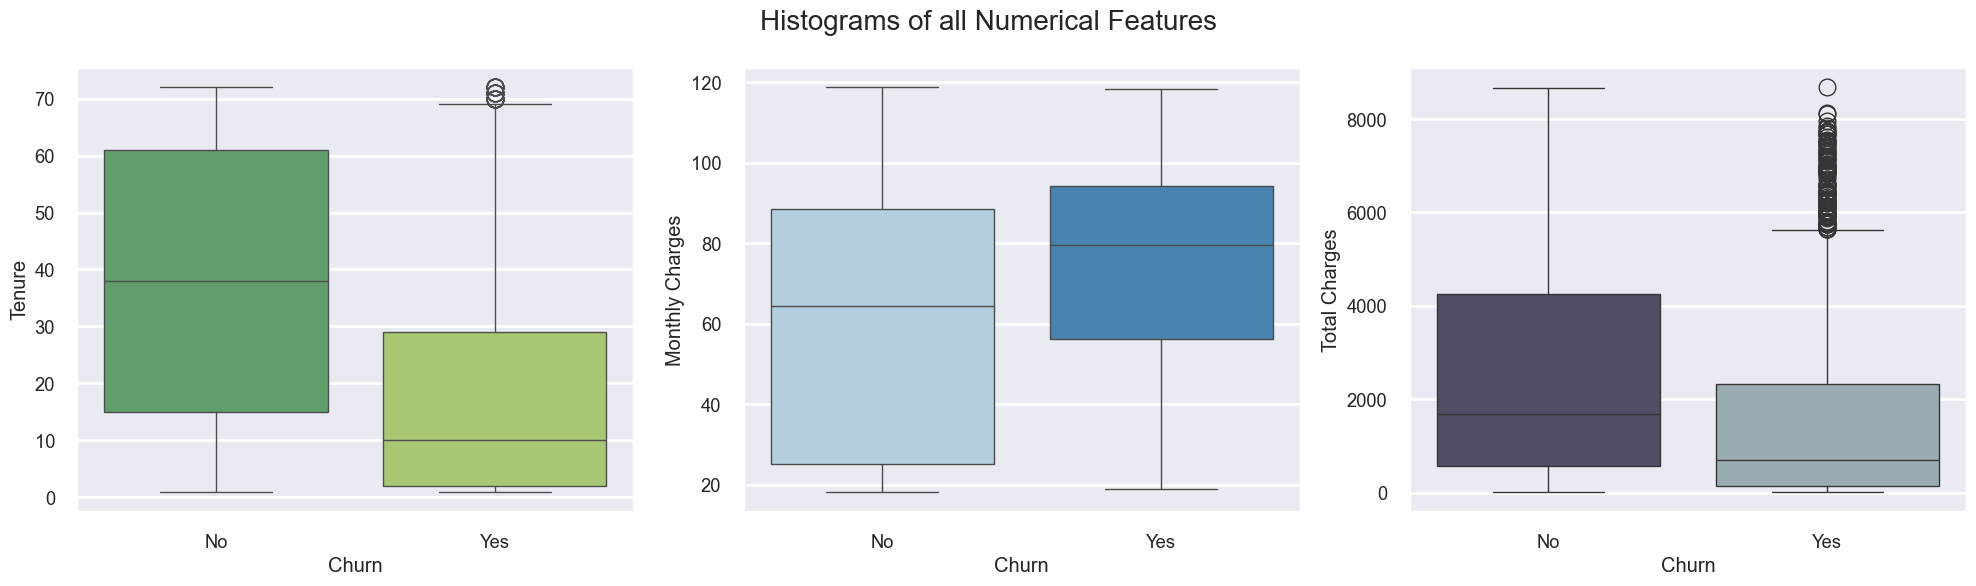

In [20]:
sns.set_context('poster', font_scale= 0.6)
fig, ax  = plt.subplots(1, 3, figsize=(20, 6))

plt.suptitle('Histograms of all Numerical Features', fontsize = 20)

ax1 = sns.boxplot(y = data['tenure'], x= data['Churn'], ax= ax[0], palette= 'summer')
ax1.set(xlabel= 'Churn', ylabel= 'Tenure')

ax2 = sns.boxplot(y = data['MonthlyCharges'], x= data['Churn'], ax= ax[1], palette= 'Blues')
ax2.set(xlabel= 'Churn', ylabel= 'Monthly Charges')

ax3 = sns.boxplot(y = data['TotalCharges'], x= data['Churn'], ax= ax[2], palette= 'bone')
ax3.set(xlabel= 'Churn', ylabel= 'Total Charges')

plt.tight_layout()
plt.show()

In [21]:
plt.figure(figsize=(10, 6))
sns.heatmap(data.corr(), cmap = 'YlGnBu', annot = True)

ValueError: could not convert string to float: 'Female'

<Figure size 1000x600 with 0 Axes>

There is definitely some correlation between tenure and total charges

Let us also check out the how our categorical variables change based on our target variable

In [ ]:
fig, ax = plt.subplots(2, 2, figsize = (15, 10))
plt.suptitle('Count plot for various categorical features', fontsize = 30, color= 'teal')

ax1 = sns.countplot(x ='gender', data= data, hue= 'Churn', ax= ax[0, 0], palette= 'spring')
ax1.set(xlabel = 'Gender')

ax2 = sns.countplot(x ='SeniorCitizen', data= data, hue= 'Churn', ax= ax[0, 1], palette= 'winter')
ax2.set(xlabel = 'Senior Citizen')

ax3 = sns.countplot(x ='Partner', data= data, hue= 'Churn', ax= ax[1, 0], palette= 'summer')
ax3.set(xlabel = 'Partner')

ax4 = sns.countplot(x ='Dependents', data= data, hue= 'Churn', ax= ax[1, 1], palette= 'viridis')
ax4.set(xlabel = 'Dependents')

plt.tight_layout()
plt.show()

Based on the `demographic information`, it is clear that Senior Citizens are much more likely to churn, also, customers not having a partner have higher chances of churning as compared to customers who do have a partner.

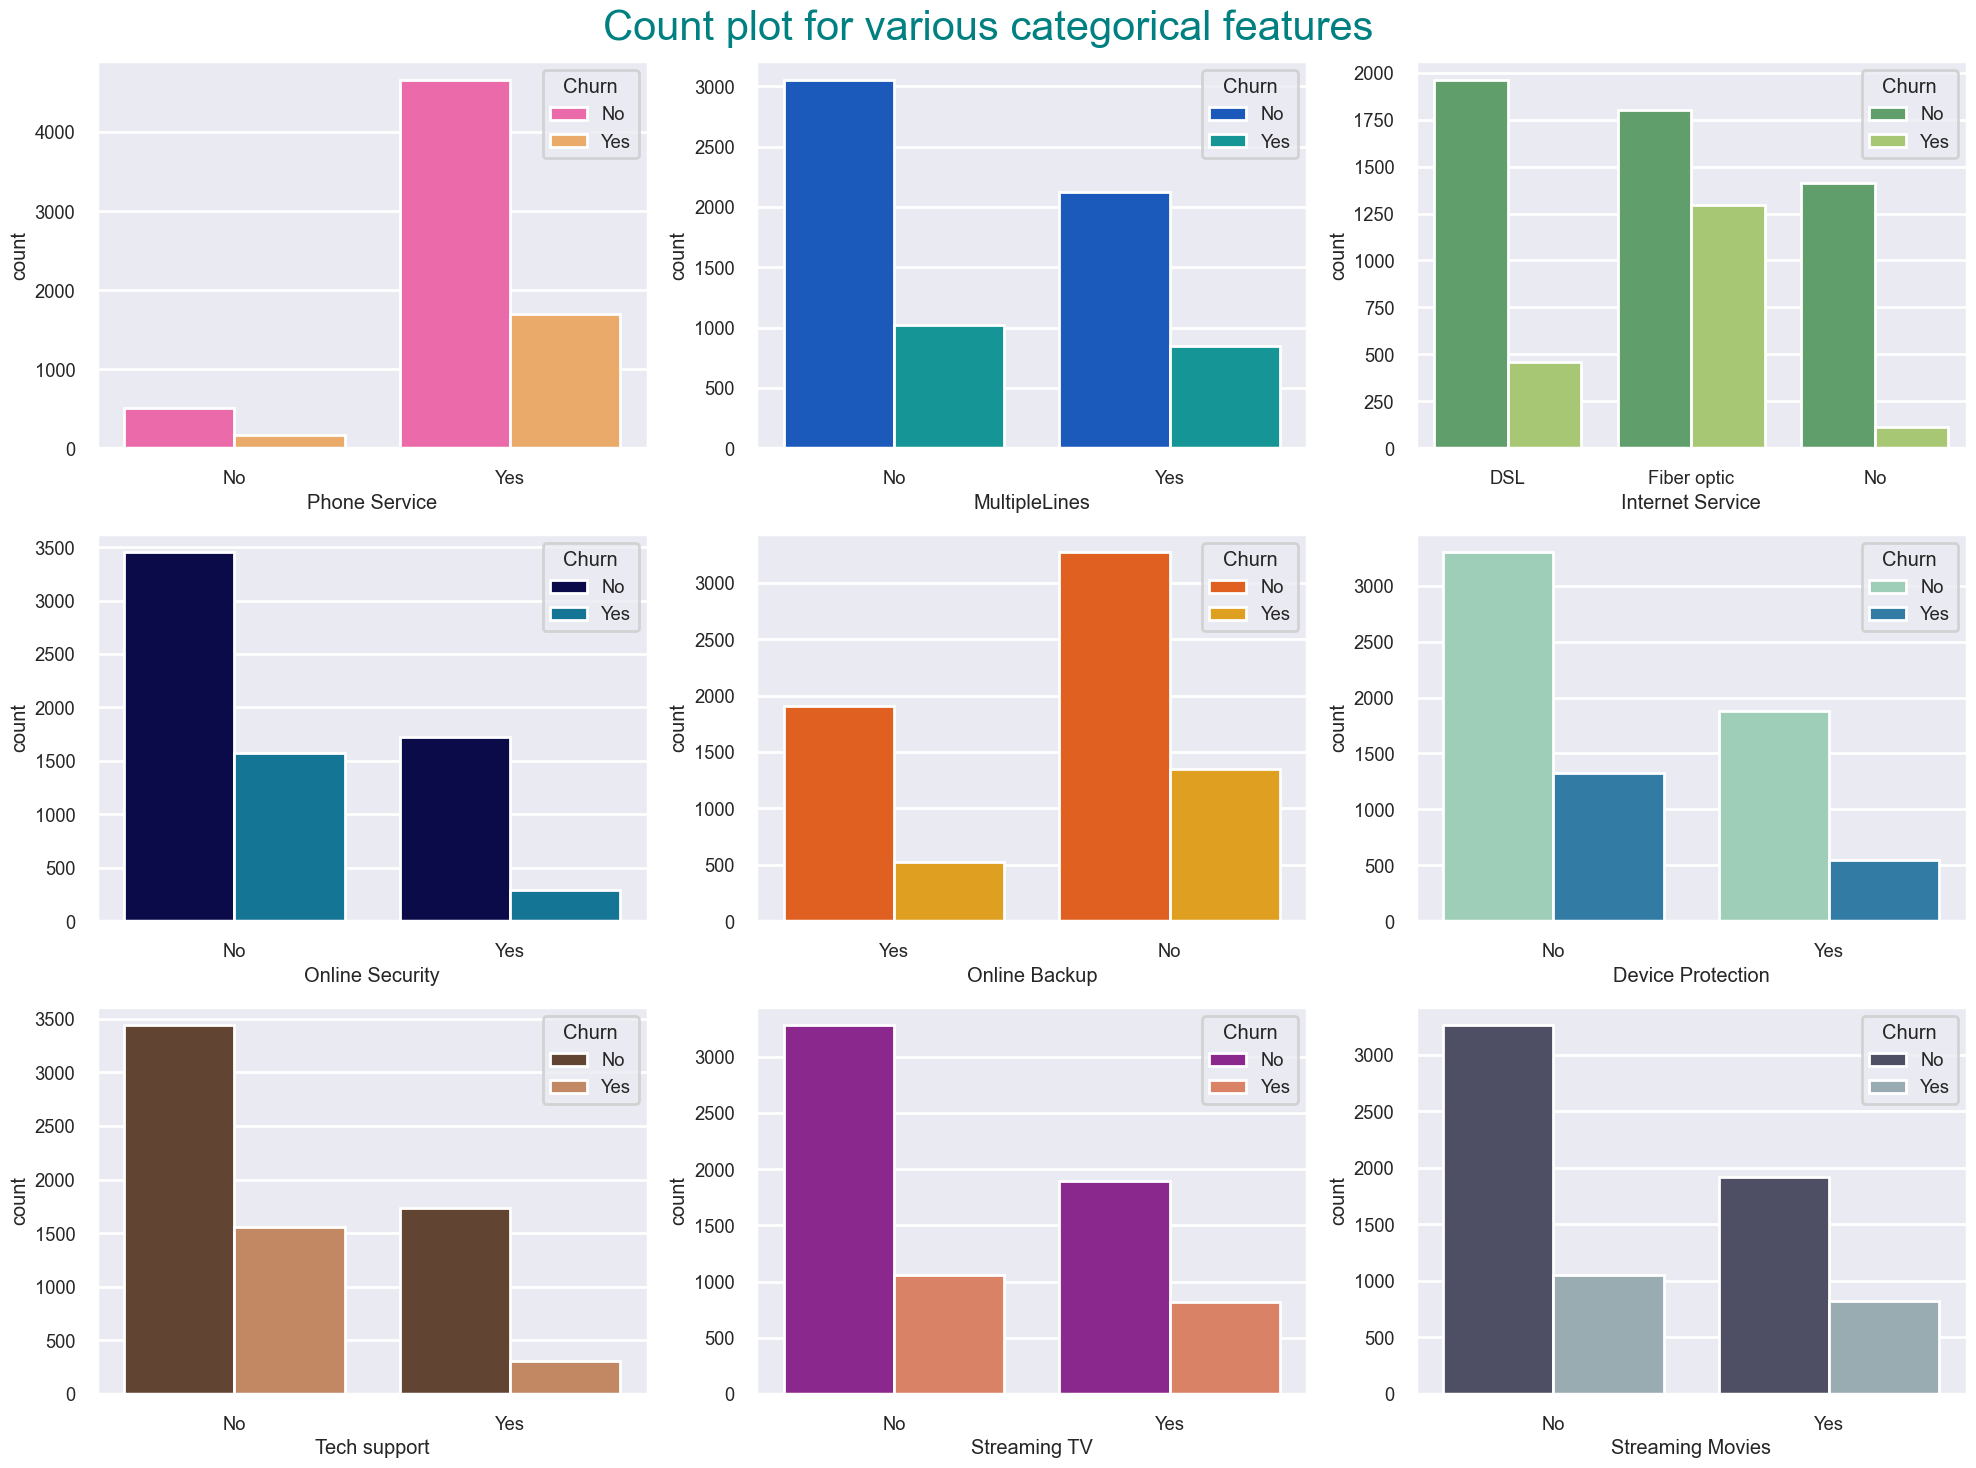

In [22]:
fig, ax = plt.subplots(3, 3, figsize = (20, 15))

plt.suptitle('Count plot for various categorical features', fontsize = 30, color= 'teal')

ax1 = sns.countplot(x ='PhoneService', data= data, hue= 'Churn', ax= ax[0, 0], palette= 'spring')
ax1.set(xlabel = 'Phone Service')

ax2 = sns.countplot(x ='MultipleLines', data= data, hue= 'Churn', ax= ax[0, 1], palette= 'winter')
ax2.set(xlabel = 'MultipleLines')

ax3 = sns.countplot(x ='InternetService', data= data, hue= 'Churn', ax= ax[0, 2], palette= 'summer')
ax3.set(xlabel = 'Internet Service')

ax4 = sns.countplot(x ='OnlineSecurity', data= data, hue= 'Churn', ax= ax[1, 0], palette= 'ocean')
ax4.set(xlabel = 'Online Security')

ax5 = sns.countplot(x ='OnlineBackup', data= data, hue= 'Churn', ax= ax[1, 1], palette= 'autumn')
ax5.set(xlabel = 'Online Backup')

ax6 = sns.countplot(x ='DeviceProtection', data= data, hue= 'Churn', ax= ax[1, 2], palette= 'YlGnBu')
ax6.set(xlabel = 'Device Protection')

ax7 = sns.countplot(x ='TechSupport', data= data, hue= 'Churn', ax= ax[2, 0], palette= 'copper')
ax7.set(xlabel = 'Tech support')

ax8 = sns.countplot(x ='StreamingTV', data= data, hue= 'Churn', ax= ax[2, 1], palette= 'plasma')
ax8.set(xlabel = 'Streaming TV')

ax9 = sns.countplot(x ='StreamingMovies', data= data, hue= 'Churn', ax= ax[2, 2], palette= 'bone')
ax9.set(xlabel = 'Streaming Movies')

plt.tight_layout()
plt.show()

**Inference** : Customers having Fiber optic internet service are much more likely to churn then customers who don't

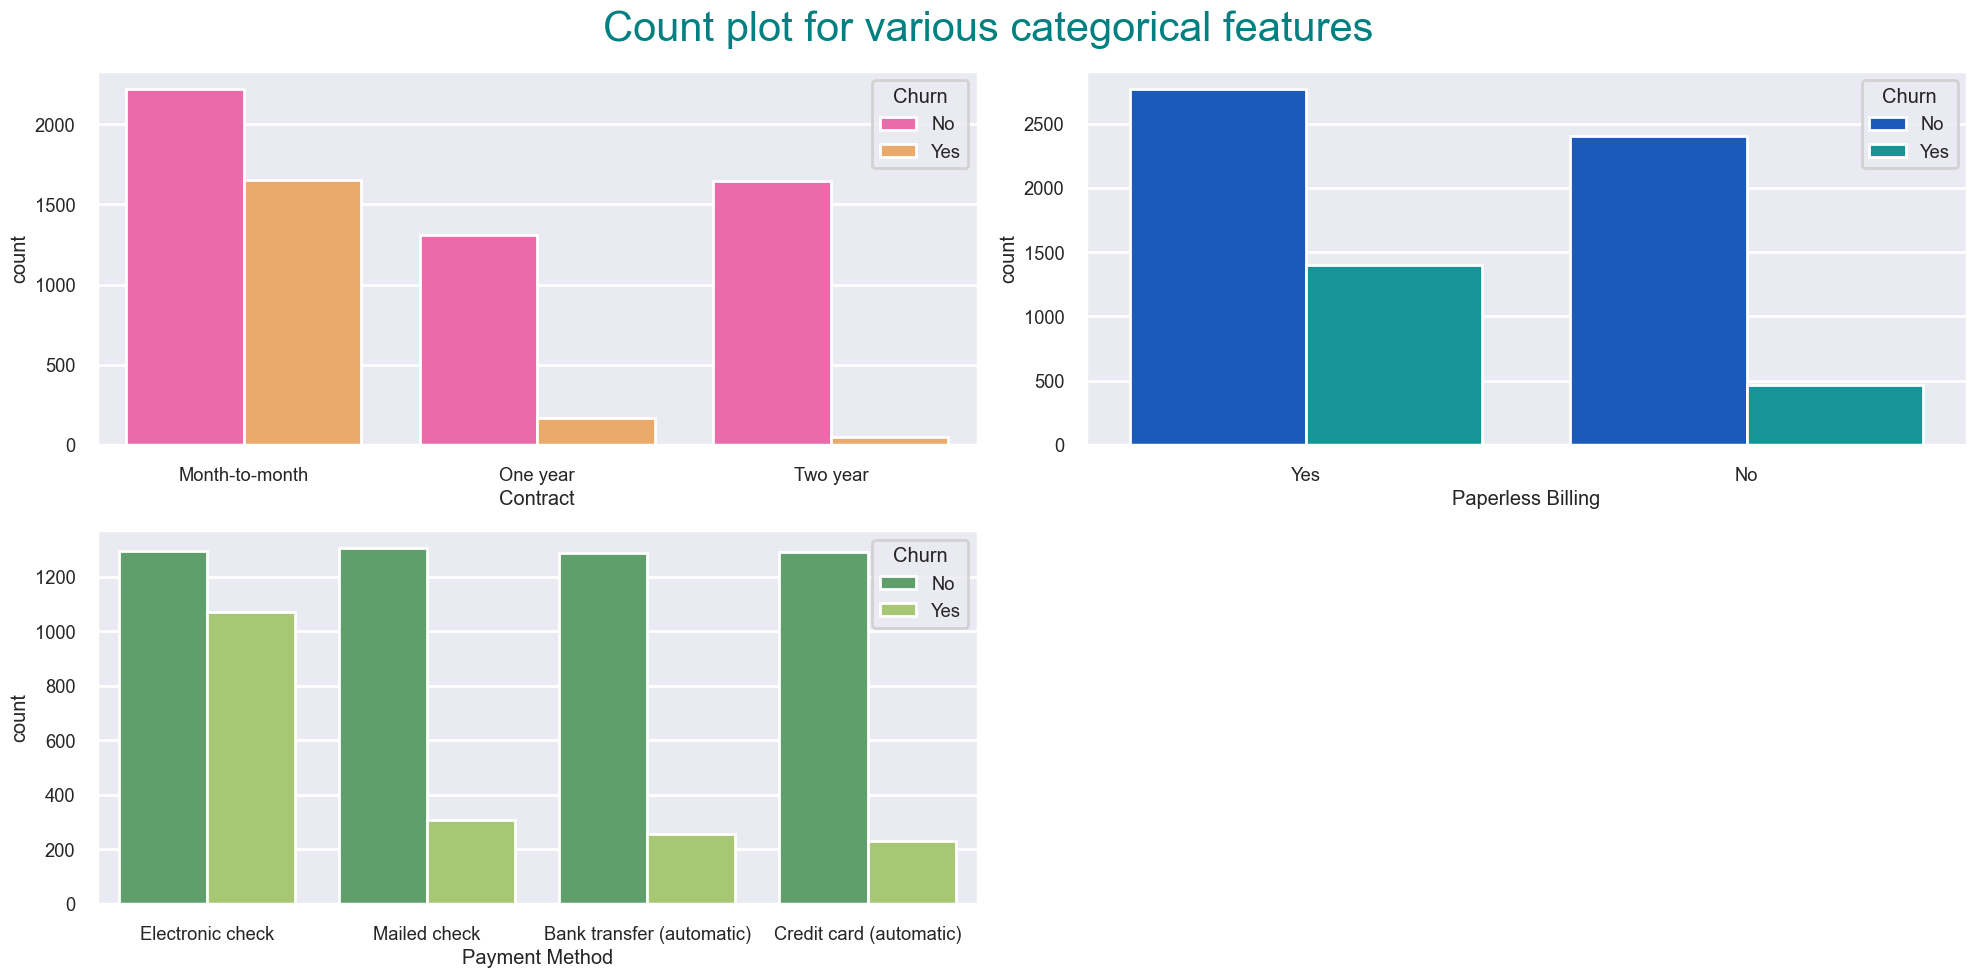

In [23]:
fig, ax = plt.subplots(2, 2, figsize = (20, 10))
ax[1, 1].axis('off')

plt.suptitle('Count plot for various categorical features', fontsize = 30, color= 'teal')

ax1 = sns.countplot(x ='Contract', data= data, hue= 'Churn', ax= ax[0, 0], palette= 'spring')
ax1.set(xlabel = 'Contract')

ax2 = sns.countplot(x ='PaperlessBilling', data= data, hue= 'Churn', ax= ax[0, 1], palette= 'winter')
ax2.set(xlabel = 'Paperless Billing')

ax3 = sns.countplot(x ='PaymentMethod', data= data, hue= 'Churn', ax= ax[1, 0], palette= 'summer')
ax3.set(xlabel = 'Payment Method')

plt.tight_layout()
plt.show()

Based on the `Account` information, customers having longer contracts are much more less likely to churn. Also, customers who use Electronic Check as a payment method have higher chances of churning then customers who use other methods

### Updated:  **Missing Values**

In [24]:
data.isna().sum()

gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

Luckily, there are no missing values in this dataset

### Updated:  **Checking For Skewness**

In [25]:
skew_df = pd.DataFrame(data.select_dtypes(np.number).columns, columns=['Feature'])
skew_df['Skew'] = skew_df['Feature'].apply(lambda feature: skew(data[feature]))
skew_df['Absolute Skew'] = skew_df['Skew'].apply(abs)
skew_df

,Feature,Skew,Absolute Skew
0,tenure,0.238505,0.238505
1,MonthlyCharges,-0.220477,0.220477
2,TotalCharges,0.963584,0.963584


Total Charges column is clearly skewed as we also saw in the histogram, so lets apply log transformation to it

In [26]:
data['TotalCharges'] = np.log(data['TotalCharges'])

### Updated:  **Encoding**

In this dataset, we have lots of categorical columns and some follow a certain order. So we will need to apply different kinds of encoding to different categorical features

Binary Encoding

In [27]:
binary_columns = ['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines',
                   'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
                   'StreamingTV', 'StreamingMovies', 'PaperlessBilling', 'Churn']

le = LabelEncoder()
for column in binary_columns:
    data[column] = le.fit_transform(data[column])

One Hot Encoding

In [28]:
dummies_payment = pd.get_dummies(data['PaymentMethod'], drop_first= True)
data = pd.concat([data, dummies_payment], axis=1)
data.drop('PaymentMethod',axis =1 , inplace= True)

Ordinal Encoding

In [29]:
internet_ordering = ['No', 'DSL', 'Fiber optic']
contract_ordering = ['Month-to-month', 'One year', 'Two year']

data['InternetService'] = data['InternetService'].apply(lambda x: internet_ordering.index(x))
data['Contract'] = data['Contract'].apply(lambda x: contract_ordering.index(x))

### Updated:  **Scaling**

In [30]:
X = data.drop('Churn', axis= 1)
y = data['Churn']

In [31]:
sc = StandardScaler()
X = sc.fit_transform(X)

### Updated:  **Splitting**

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2, stratify= y, random_state= 42)

In [33]:
print(y_train.value_counts())
print(y_test.value_counts())

Churn
0    4139
1    1495
Name: count, dtype: int64
Churn
0    1035
1     374
Name: count, dtype: int64


### Updated:  **Modelling**

In [34]:
models = {
    'logistic regression' : LogisticRegression(),
    'xgboost' : XGBClassifier(),
    'catboost' : CatBoostClassifier(verbose=0),
    'lightbgm' : LGBMClassifier(),
    'gradient boosing' : GradientBoostingClassifier(),
    'naive bayes' : GaussianNB(),
    'random forest' : RandomForestClassifier()
}

In [35]:
for name, model in models.items():
    model.fit(X_train, y_train)
    print(f'{name} trained')

logistic regression trained
xgboost trained
catboost trained
[LightGBM] [Info] Number of positive: 1495, number of negative: 4139
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000666 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 639
[LightGBM] [Info] Number of data points in the train set: 5634, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.265353 -> initscore=-1.018328
[LightGBM] [Info] Start training from score -1.018328
lightbgm trained
gradient boosing trained
naive bayes trained
random forest trained


### Updated:  **Evaluation**

In [36]:
results = {}

kf = KFold(n_splits= 10)

for name, model in models.items():
    result = cross_val_score(model, X_train, y_train, scoring= 'roc_auc', cv= kf)
    results[name] = result

[LightGBM] [Info] Number of positive: 1348, number of negative: 3722
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000494 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 639
[LightGBM] [Info] Number of data points in the train set: 5070, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.265878 -> initscore=-1.015639
[LightGBM] [Info] Start training from score -1.015639
[LightGBM] [Info] Number of positive: 1351, number of negative: 3719
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000243 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 639
[LightGBM] [Info] Number of data points in the train set: 5070, number of used features: 21
[LightGBM] [Info] [binary:

In [37]:
for name, result in results.items():
    print("----------------")
    print(f'{name} : {np.mean(result)}')

----------------
logistic regression : 0.8508786257696552
----------------
xgboost : 0.8205718013642068
----------------
catboost : 0.8413070420408486
----------------
lightbgm : 0.8360262959501084
----------------
gradient boosing : 0.8452366731602691
----------------
naive bayes : 0.8338557401940768
----------------
random forest : 0.8246410443906044


Logistic regression seems to be the winner here. Let us perform some hyperparameter optimization and also check its accuracy on the test set

### Updated:  **Hyperparameter Optimization**

In [38]:
def lr_objective(trial):
    tol = trial.suggest_loguniform('tol', 1e-7, 0.1)
    C = trial.suggest_float('C', 0, 0.1)
    max_iter = trial.suggest_int('max_iter', 50, 600)
    penalty = trial.suggest_categorical('penalty', ['l1', 'l2'])

    model = LogisticRegression(
        solver= 'liblinear',
        penalty = penalty,
        tol= tol,
        C= C,
        max_iter= max_iter
    )

    model.fit(X_train, y_train)
    cv_score = cross_val_score(model, X_train, y_train, scoring= 'roc_auc', cv= kf)

    return np.mean(cv_score)

study = optuna.create_study(direction= 'maximize')
study.optimize(lr_objective, n_trials= 100)

[I 2024-10-17 09:03:59,395] A new study created in memory with name: no-name-c415f385-569a-41be-8ab9-7063b25f3d92
/var/folders/f6/s8p4_84101l8gy61qszps_c40000gn/T/ipykernel_11867/1897857987.py:2: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  tol = trial.suggest_loguniform('tol', 1e-7, 0.1)
[I 2024-10-17 09:03:59,865] Trial 0 finished with value: 0.8509987065869261 and parameters: {'tol': 3.704767872797539e-07, 'C': 0.06489148963949996, 'max_iter': 386, 'penalty': 'l1'}. Best is trial 0 with value: 0.8509987065869261.
/var/folders/f6/s8p4_84101l8gy61qszps_c40000gn/T/ipykernel_11867/1897857987.py:2: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  tol = trial.suggest_logunif

In [39]:
study.best_params

{'tol': 0.0007552687147258738,
 'C': 0.09969332364834317,
 'max_iter': 130,
 'penalty': 'l1'}

In [40]:
lr = LogisticRegression(
    solver = 'liblinear',
    tol = 0.008408625396645686,
    C = 0.08440490508701622,
    max_iter = 434,
    penalty = 'l1')

lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)
y_pred_prob = lr.predict_proba(X_test)[:, 1]

In [41]:
print("Actual values    :", y_test.values[:20])
print("Predicted values :", y_pred[:20])

Actual values    : [0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0]
Predicted values : [0 1 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 1 0 0]


In [42]:
predictions = pd.DataFrame({'Probability of Customer Churning': y_pred_prob, 'Probability of customer not churning' : 1 - y_pred_prob})
predictions.head()

,Probability of Customer Churning,Probability of customer not churning
0,0.059578,0.940422
1,0.680888,0.319112
2,0.065164,0.934836
3,0.324485,0.675515
4,0.033615,0.966385


In [43]:
print('ROC AUC Score:', round(roc_auc_score(y_test, y_pred_prob), 3))

ROC AUC Score: 0.849


We have a ROC score of 0.85 which is similar to what we got earlier

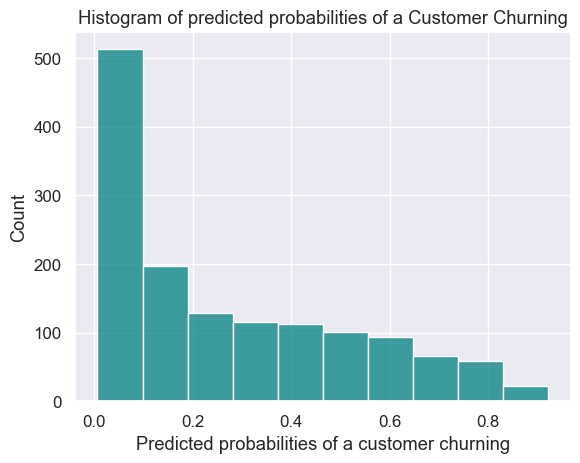

In [44]:
sns.set_context('notebook', font_scale= 1.1)
sns.histplot(y_pred_prob, bins= 10, color= 'teal')
plt.title('Histogram of predicted probabilities of a Customer Churning')
plt.xlabel('Predicted probabilities of a customer churning')
plt.show()

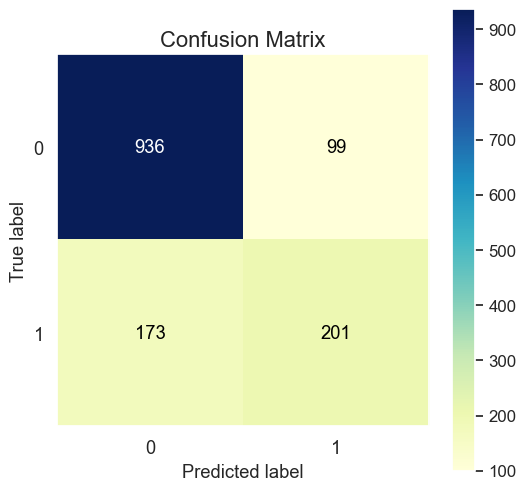

In [45]:
skplt.metrics.plot_confusion_matrix(y_test, y_pred, figsize=(6,6), cmap= 'YlGnBu');

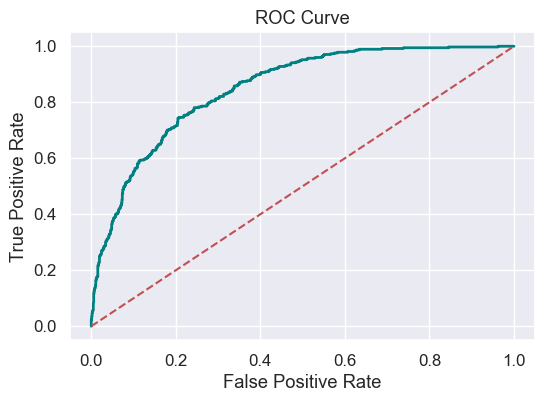

In [46]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, linewidth=2, color= 'teal')
plt.plot([0,1], [0,1], 'r--' )
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.show()

### Updated:  **ANN**

In [47]:
X_train.shape

(5634, 21)

In [ ]:
model = tf.keras.Sequential([
    tf.keras.Input(shape=(21,)),  # Fix: Input shape must be a tuple
    tf.keras.layers.Dense(50, activation='relu'),
    tf.keras.layers.Dense(50, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', min_delta=0, patience=5, verbose=0,
    mode='auto', baseline=None, restore_best_weights=True
)

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=[tf.keras.metrics.AUC(name='auc')]
)

BATCH_SIZE = 100
EPOCHS = 10

history = model.fit(
    X_train,
    y_train,
    validation_split=0.20,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    verbose=0,
    callbacks=[early_stopping]  # Fix: Pass callbacks as
)

In [ ]:
history.history.keys()

### Updated:  **Plotting Results**

In [ ]:
plt.figure(figsize=(10, 6))

epochs = range(1, EPOCHS + 1)
train_loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(epochs, train_loss, label="Training Loss")
plt.plot(epochs, val_loss, label="Validation Loss")

plt.title("Training and Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.show()

In [ ]:
np.argmin(val_loss)

Validation loss isn't changing that much after 6th epoch and our model has probably started overfitting after that

In [ ]:
model.evaluate(X_test, y_test)

We have an auc of 0.84 which is definitely not that bad, so our neural network seems to be doing a good job